In [1]:
import json
import numpy as np
import pandas as pd
import requests

In [2]:
def get_json(api_url):
	response = requests.get(api_url)
	if response.status_code == 200:
		return json.loads(response.content.decode('utf-8'))
	else:
		return None

In [3]:
record_date = '2020-08-17'
covid_url = 'https://covid19-api.org/api/status?date='+record_date
df_covid_worldwide = pd.io.json.json_normalize(get_json(covid_url))

df_covid_worldwide.head()

,country,last_update,cases,deaths,recovered
0,US,2020-08-16T23:27:50,5401167,170019,1833067
1,BR,2020-08-16T23:27:50,3340197,107852,2655017
2,IN,2020-08-16T23:27:50,2589682,49980,1862258
3,RU,2020-08-16T23:27:50,920719,15653,731444
4,ZA,2020-08-16T23:27:50,587345,11839,472377


In [4]:
df_covid_worldwide['last_update'] = pd.to_datetime(df_covid_worldwide['last_update'], format='%Y-%m-%d %H:%M:%S')
df_covid_worldwide['last_update'] = df_covid_worldwide['last_update'].apply(lambda x: x.date())

In [5]:
countries_url = 'https://covid19-api.org/api/countries'
df_countries = pd.io.json.json_normalize(get_json(countries_url))
df_countries = df_countries.rename(columns={'alpha2': 'country'})[['name','country']]

print(df_countries.head())

          name country
0  Afghanistan      AF
1      Albania      AL
2      Algeria      DZ
3      Andorra      AD
4       Angola      AO


In [6]:
df_covid_denormalized = pd.merge(df_covid_worldwide, df_countries, on='country')

print(df_covid_denormalized.head())

  country last_update    cases  deaths  recovered                      name
0      US  2020-08-16  5401167  170019    1833067  United States of America
1      BR  2020-08-16  3340197  107852    2655017                    Brazil
2      IN  2020-08-16  2589682   49980    1862258                     India
3      RU  2020-08-16   920719   15653     731444        Russian Federation
4      ZA  2020-08-16   587345   11839     472377              South Africa


In [7]:
df_covid_denormalized['fatality_ratio'] = df_covid_denormalized['deaths']/df_covid_denormalized['cases']

In [8]:
df_top_20_fatality_rate = df_covid_denormalized.sort_values(by='fatality_ratio', ascending=False).head(20)

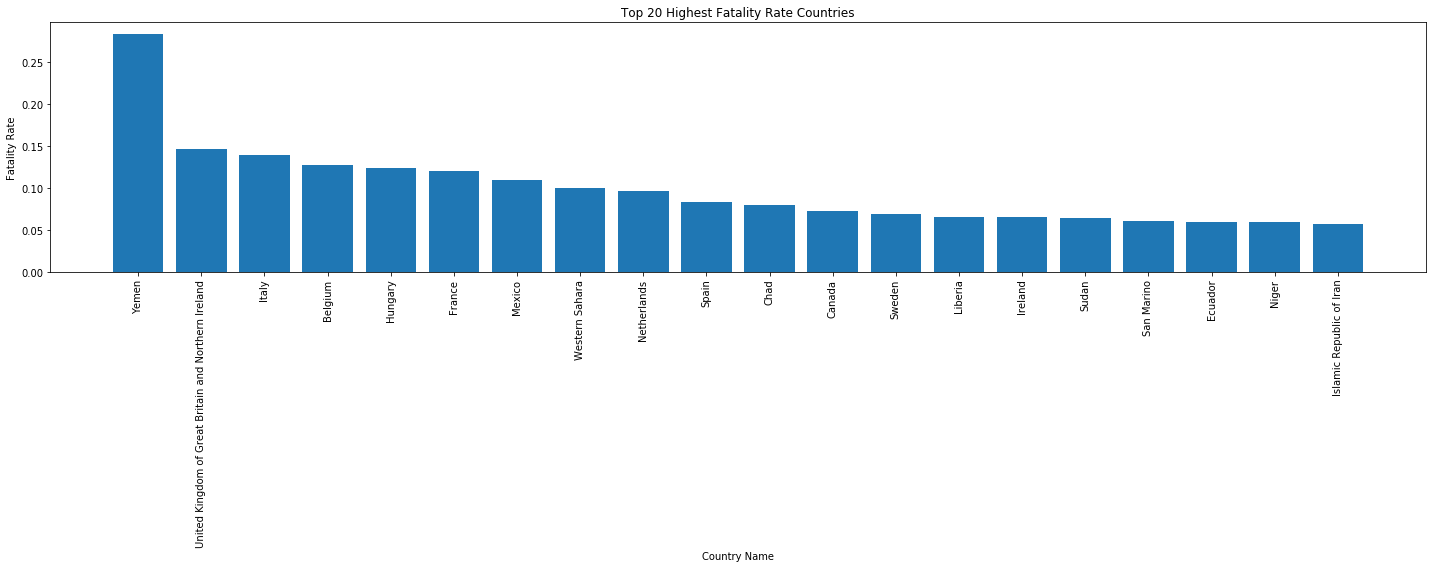

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
x = df_top_20_fatality_rate['name']
y = df_top_20_fatality_rate['fatality_ratio']
plt.bar(x,y)
plt.xlabel('Country Name')
plt.ylabel('Fatality Rate')
plt.title('Top 20 Highest Fatality Rate Countries')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [15]:
countries = ['ID','MY','SG','TH','VN']
i = 0
for country in countries:
	covid_timeline_url = 'https://covid19-api.org/api/timeline/'+country
	df_covid_timeline = pd.io.json.json_normalize(get_json(covid_timeline_url))
	df_covid_timeline['last_update'] = pd.to_datetime(df_covid_timeline['last_update'], format='%Y-%m-%dT%H:%M:%S')
	df_covid_timeline['last_update'] = df_covid_timeline['last_update'].apply(lambda x: x.date())
	if i==0:
		df_covid_timeline_merged = df_covid_timeline
	else:
		df_covid_timeline_merged = df_covid_timeline.append(df_covid_timeline_merged, ignore_index=True)
	i=i+1
    
print(df_covid_timeline_merged.head())

  country last_update  cases  deaths  recovered
0      VN  2021-01-31   1812      35       1456
1      VN  2021-01-30   1767      35       1456
2      VN  2021-01-29   1657      35       1448
3      VN  2021-01-28   1560      35       1430
4      VN  2021-01-27   1551      35       1430


In [22]:
df_covid_timeline_denormalized = pd.merge(df_covid_timeline_merged, df_countries, on='country')
df_covid_timeline_denormalized.head()

,country,last_update,cases,deaths,recovered,name
0,VN,2021-01-31,1812,35,1456,Viet Nam
1,VN,2021-01-30,1767,35,1456,Viet Nam
2,VN,2021-01-29,1657,35,1448,Viet Nam
3,VN,2021-01-28,1560,35,1430,Viet Nam
4,VN,2021-01-27,1551,35,1430,Viet Nam


In [18]:
import datetime
df_covid_timeline_denormalized = df_covid_timeline_denormalized[(df_covid_timeline_denormalized['last_update'] >= datetime.date(2020, 3, 1))]

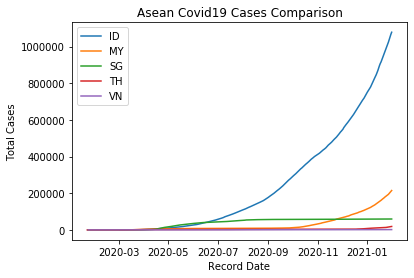

In [23]:
import matplotlib.pyplot as plt
plt.clf()
countries = ['ID','MY','SG','TH','VN']
for country in countries:
	country_data = df_covid_timeline_denormalized['country']== country
	x = df_covid_timeline_denormalized[country_data]['last_update']
	y = df_covid_timeline_denormalized[country_data]['cases']
	plt.plot(x, y, label = country)

plt.legend()
plt.xlabel('Record Date')
plt.ylabel('Total Cases')
plt.title('Asean Covid19 Cases Comparison')
plt.show()